In [3]:
#importing the neccessary libraries
import glob
import cv2 as cv
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pathlib
import splitfolders
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
#from google.colab import drive
#!pip install split-folders

In [4]:
#load and read the images
url = "../input/dl-images/dataset1/dataset1/known_images"
image_dir = pathlib.Path(url)
image_dir
#unknow_dir

PosixPath('../input/dl-images/dataset1/dataset1/known_images')

In [5]:
splitfolders.ratio(image_dir, output='imgs', seed=123, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 715 files [00:02, 339.12 files/s]


In [6]:
normal = [fn for fn in os.listdir(f'{image_dir}/normal') if fn.endswith('.png')]
sick = [fn for fn in os.listdir(f'{image_dir}/sick') if fn.endswith('.png')]

image = [normal, sick]
image_class = []

for i in os.listdir('imgs/train'):
  image_class+=[i]
image_class.sort()

In [7]:
image_count = len(list(image_dir.glob('*/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(image_class)}')
count = 0
images_count = []
for x in image_class:
  print(f'Total {x} images: {len(image[count])}')
  images_count.append(len(image[count]))
  count += 1


Total images: 715
Total number of classes: 2
Total normal images: 364
Total sick images: 351


In [8]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in image_class:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

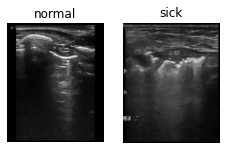

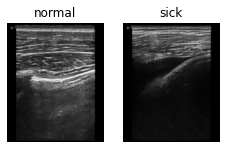

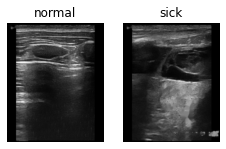

In [9]:
for i in range(3):
  load_random_img(image_dir, image_class)

image preprocessing

In [10]:
batch_size = 32
img_height, img_width = 390, 390
input_shape = (img_height, img_width, 3)

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)



Found 571 images belonging to 2 classes.
Found 71 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [13]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

VGG16 Model

In [14]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

2022-08-18 12:33:55.991515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:33:56.074824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:33:56.075610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:33:56.077635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 390, 390, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 12, 12, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 15,242,050
Trainable params: 527,362
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/cnn_model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [17]:
learning1 = model_vgg16.fit(train_ds, epochs = 30, validation_data = val_ds, callbacks=callbacks)

2022-08-18 12:34:21.269699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-18 12:34:22.867114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 25s 717ms/step - loss: 0.7282 - accuracy: 0.5534 - val_loss: 0.7278 - val_accuracy: 0.5070

Epoch 00001: val_accuracy improved from -inf to 0.50704, saving model to saved_models/cnn_model.hdf5
Epoch 2/30
18/18 [==============================] - 6s 309ms/step - loss: 0.5876 - accuracy: 0.6445 - val_loss: 0.5131 - val_accuracy: 0.7606

Epoch 00002: val_accuracy improved from 0.50704 to 0.76056, saving model to saved_models/cnn_model.hdf5
Epoch 3/30
18/18 [==============================] - 6s 304ms/step - loss: 0.4733 - accuracy: 0.8039 - val_loss: 0.5090 - val_accuracy: 0.7324

Epoch 00003: val_accuracy did not improve from 0.76056
Epoch 4/30
18/18 [==============================] - 5s 300ms/step - loss: 0.4038 - accuracy: 0.8669 - val_loss: 0.3812 - val_accuracy: 0.8732

Epoch 00004: val_accuracy improved from 0.76056 to 0.87324, saving model to saved_models/cnn_model.hdf5
Epoch 5/30
18/18 [==============================] - 5s 291ms/step - loss: 

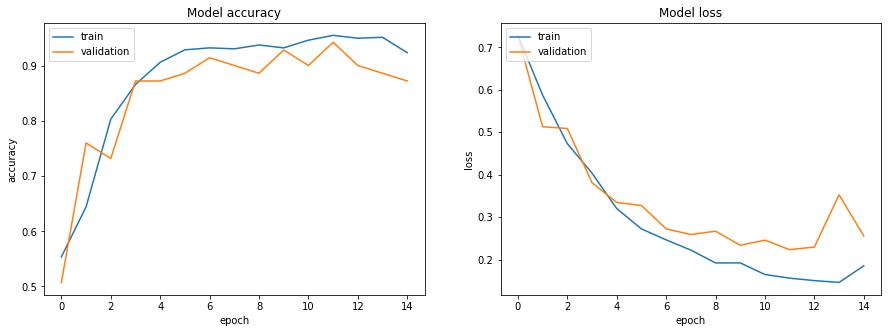

In [18]:
model_vgg16.load_weights('saved_models/cnn_model.hdf5')
plot_train_history(learning1)

In [19]:
score1 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 2 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')

3/3 [==============================] - 3s 1s/step - loss: 0.1813 - accuracy: 0.9452
Model 2 VGG16 Loss: 0.18134289979934692, Accuracy: 94.52054500579834


FInetune the model

In [20]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
learning2 = model_vgg16.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks=callbacks)

Epoch 1/10
18/18 [==============================] - 18s 788ms/step - loss: 0.1733 - accuracy: 0.9405 - val_loss: 0.2245 - val_accuracy: 0.9155

Epoch 00001: val_accuracy did not improve from 0.94366
Epoch 2/10
18/18 [==============================] - 12s 643ms/step - loss: 0.0720 - accuracy: 0.9737 - val_loss: 0.0988 - val_accuracy: 0.9859

Epoch 00002: val_accuracy improved from 0.94366 to 0.98592, saving model to saved_models/cnn_model.hdf5
Epoch 3/10
18/18 [==============================] - 12s 647ms/step - loss: 0.0375 - accuracy: 0.9877 - val_loss: 0.1237 - val_accuracy: 0.9437

Epoch 00003: val_accuracy did not improve from 0.98592
Epoch 4/10
18/18 [==============================] - 12s 642ms/step - loss: 0.0208 - accuracy: 0.9965 - val_loss: 0.0899 - val_accuracy: 0.9859

Epoch 00004: val_accuracy did not improve from 0.98592
Epoch 5/10
18/18 [==============================] - 12s 650ms/step - loss: 0.0138 - accuracy: 0.9947 - val_loss: 0.1055 - val_accuracy: 0.9718

Epoch 00005

In [22]:
model_vgg16.load_weights('saved_models/cnn_model.hdf5')

In [23]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 2 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score2[0]}, Accuracy: {score2[1]*100}')

3/3 [==============================] - 1s 151ms/step - loss: 0.0762 - accuracy: 0.9726
Model 2 VGG16 Loss: 0.18134289979934692, Accuracy: 94.52054500579834
Model 2 VGG16 Fine-tuned Loss: 0.07618812471628189, Accuracy: 97.26027250289917


In [24]:
Y_pred = model_vgg16.predict(test_ds)

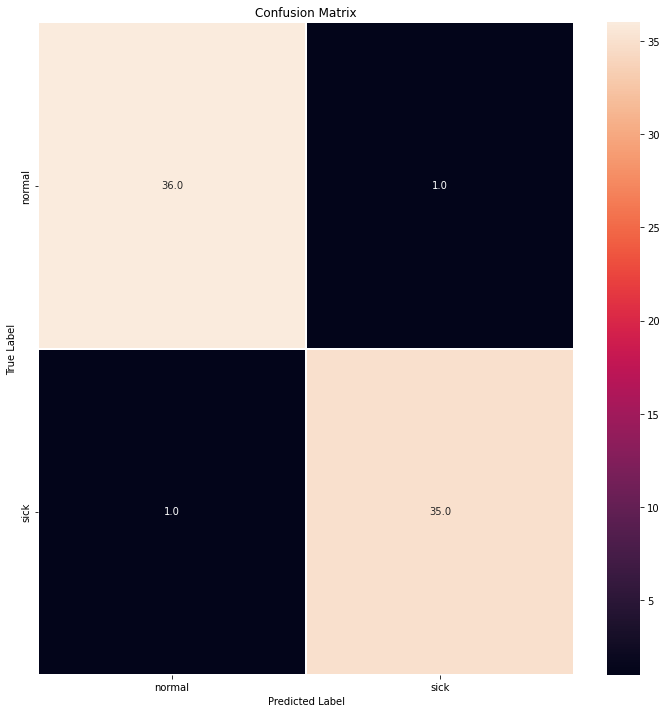

In [25]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(image_class)
plt.title("Confusion Matrix")
plt.show()

In [26]:
report2 = classification_report(test_ds.classes, y_pred, target_names=image_class, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
normal,0.972973,0.972973,0.972973,37.000000
sick,0.972222,0.972222,0.972222,36.000000
accuracy,0.972603,0.972603,0.972603,0.972603
macro avg,0.972598,0.972598,0.972598,73.000000
weighted avg,0.972603,0.972603,0.972603,73.000000


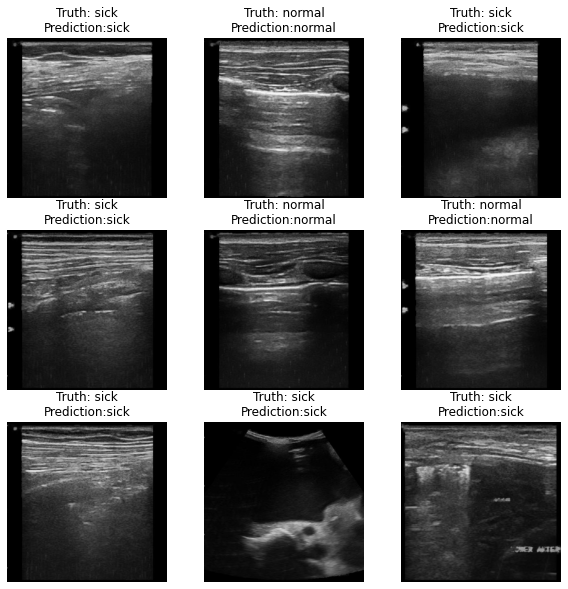

In [27]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = image_class[np.argmax(score)]
    plt.title(f'Truth: {image_class[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)